# Pitch angle scattering
Look at how electron scatters change the pitch angles of the electrons.

In [25]:
# Basic imports and settings
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
# Import scipy constants
import scipy.constants as const
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

import time

In [26]:
# Import the cross-section classes
from src.Rudd1991 import RuddXSec
from src.Mott import MottXSec
import src.Constants as myconst

In [27]:
# Make matplotlib figures better and allow latex
plt.rcParams['text.usetex'] = True
# Make figures bigger
plt.rcParams['figure.figsize'] = (8, 5)
# Make font sizes bigger
plt.rcParams.update({'font.size': 14})

## Trapping time of endpoint electrons
Look at generating monoenergetic endpoint electrons with $T = 18575$ keV. Assume these electrons are always in some flat region of the trap and see how many scatters they undergo before being ejected from the trap.

### Verify the initial electron pitch angle distribution

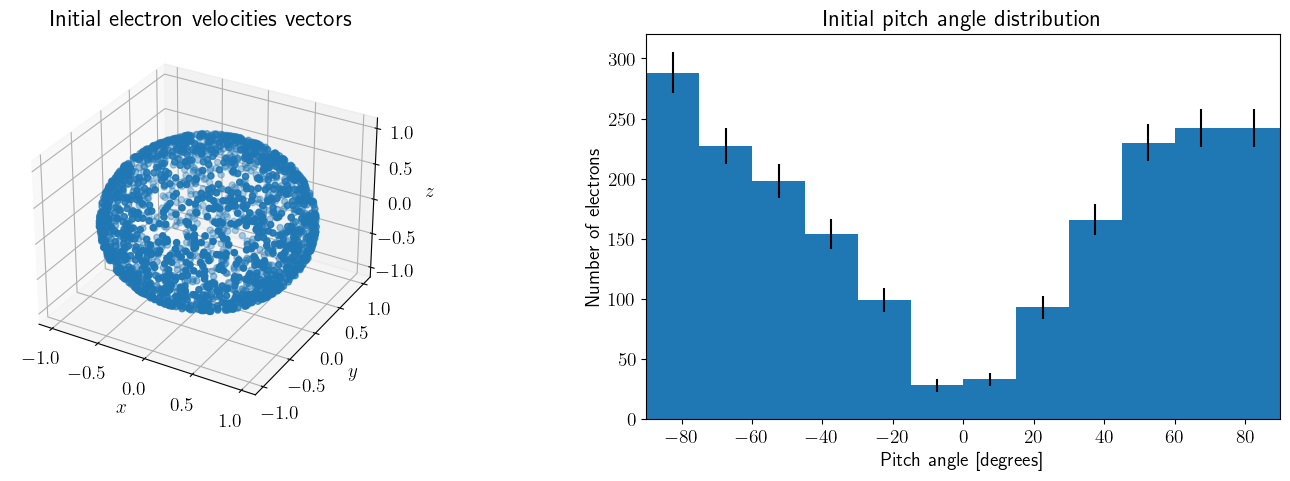

In [28]:
NELECTRONS = 2000
# Generate isotropic starting directions
theta = np.arccos(2 * np.random.rand(NELECTRONS) - 1)
phi = 2 * np.pi * np.random.rand(NELECTRONS)
xVelGen = np.sin(theta) * np.cos(phi)
yVelGen = np.sin(theta) * np.sin(phi)
zVelGen = np.cos(theta)
radialVelGen = np.sqrt(xVelGen**2 + yVelGen**2)
pitchAngleGen = np.arctan(radialVelGen / zVelGen)

# Plot these points in 3D
fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(xVelGen, yVelGen, zVelGen)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$z$")
ax.set_title('Initial electron velocities vectors')

ax2 = fig.add_subplot(122)
# Plot the pitch angle distribution histogram with error bars
y, bin_edges = np.histogram(pitchAngleGen * 180 / np.pi, bins='auto')
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
ax2.bar(bin_centers, y, width=bin_edges[1] - bin_edges[0], yerr=np.sqrt(y))
plt.xlabel('Pitch angle [degrees]')
plt.ylabel('Number of electrons')
plt.title('Initial pitch angle distribution')
plt.xlim([-90, 90])
plt.show()

### Estimating electron trapping times (single energy)
Take an electron and see how long it propagates for before leaving the trap. 

In [29]:
def CalcCDF_Rudd_SDCS_W(T):
    """
    Calculate the cumulative distribution function for the singly-differential 
    ionisation cross-section in W. 

    Parameters:
    -----------
    T : (float) The kinetic energy of the electron in eV.
    """
    # First, the values of W to be probed
    diffArr = np.logspace(-3, np.log10(T / 2.0), 100)
    WArr = (T - myconst.IONIZATIONENERGYH) * np.ones_like(diffArr) - diffArr

    # Calculate the cross-sections
    sdcsW = RuddXSec(T).SinglyDifferentialXSec_W(WArr)

    # Add a zero point to the end of the arrays
    WArr = np.append(WArr, 0.0)
    sdcsW = np.append(sdcsW, 0.0)
    # Reverse arrays
    sdcsW = np.flip(sdcsW)
    WArr = np.flip(WArr)

    # Get the normalisation constant
    sdcsWIntegral = np.trapz(sdcsW, x=WArr)

    # Create an array to store the CDF
    cdf = np.zeros_like(WArr)
    for i, W in enumerate(WArr):
        cdf[i] = np.trapz(sdcsW[:i], x=WArr[:i])

    cdf /= cdf[-1]

    return WArr, cdf

def CalcCDF_DDCS_Theta(T, W):
    """
    Calculate the CDF for the doubly-differential cross-section in theta for a
    given value of W and T.

    Parameters
    ----------
    T: Incident energy in eV
    W: Energy transfer in eV
    """
    
    nPnts = 100
    theta = np.logspace(-5, np.log10(np.pi / 2.0), nPnts)
    ddcsTheta = np.zeros_like(theta)
    for i in range(1, nPnts):
        ddcsTheta[i] = RuddXSec(T).DoublyDifferentialXSec(W, theta[i])

    cdf = np.zeros_like(theta)
    for i, th in enumerate(theta):
        cdf[i] = np.trapz(ddcsTheta[:i], x=theta[:i])

    cdf /= cdf[-1]

    return theta, cdf

def RotateToCoords(v, xAx, yAx, zAx):
    """
    Rotate a vector to a new coordinate system

    Parameters
    ----------
    v: Unit vector to be rotated
    """
    x1Prime = (xAx * v[0])[0] + (yAx * v[1])[0] + (zAx * v[2])[0]
    x2Prime = (xAx * v[0])[1] + (yAx * v[1])[1] + (zAx * v[2])[1]
    x3Prime = (xAx * v[0])[2] + (yAx * v[1])[2] + (zAx * v[2])[2]
    return np.array([x1Prime, x2Prime, x3Prime])

def GetScatteredVector(vIn, theta):
    """
    Calculation of the scattered velocity vector

    Parameters
    ----------
    vIn: Incident velocity vector
    theta: Scattering angle in radians
    """

    phiGen = 2.0 * np.pi * np.random.rand()

    # Original direction in global coordinates
    originalDir = vIn / np.linalg.norm(vIn)
    # Original direction in scattering frame
    oldDir = np.array([0.0, 0.0, 1.0])
    # New direction in scattering frame
    newDir = np.array([np.sin(theta) * np.cos(phiGen), 
                       np.sin(theta) * np.sin(phiGen), 
                       np.cos(theta)])

    # Define other axes
    ax2 = np.array([-originalDir[1] / originalDir[0], 1.0, 0.0])  
    ax2 /= np.linalg.norm(ax2)
    ax3 = np.cross(ax2, originalDir)
    ax3 /= np.linalg.norm(ax3)  

    return RotateToCoords(newDir, ax2, ax3, originalDir)

In [43]:
# Now create code for a CDF of the Mott scattering cross-section
def CalcCDF_Mott_Theta(T):
    """
    Calculate the CDF for the Mott scattering cross-section in theta for a given
    value of T.

    Parameters
    ----------
    T: Incident energy in eV
    """
    nPnts = 300
    thetaArr = np.linspace(1e-5, np.pi * 0.99999, nPnts)
    mott = MottXSec(T)
    sdcsTheta = mott.SinglyDifferentialXSec_theta(thetaArr)

    cdf = np.zeros_like(thetaArr)
    for i, th in enumerate(thetaArr):
        cdf[i] = np.trapz(sdcsTheta[:i], x=thetaArr[:i])

    cdf /= cdf[-1]

    return thetaArr, cdf

Draw some plots of the differential cross-sections and the associated cumulative distribution functions.

<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_209330/2622251001.py:15: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$d\sigma/dW$ [m$^2$ eV$^{-1}$]')


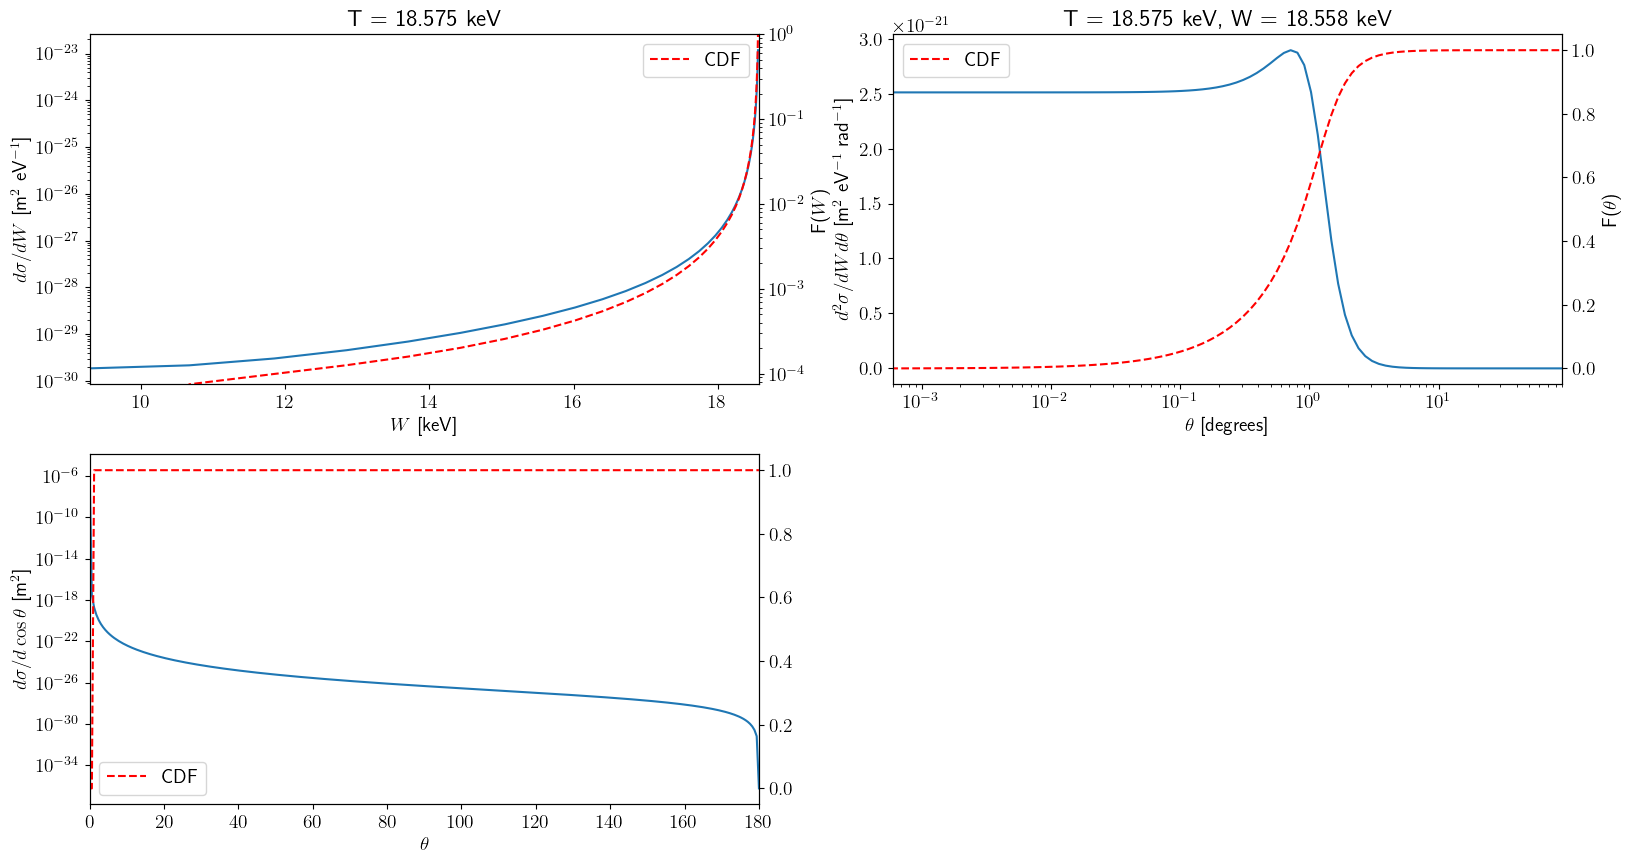

In [44]:
# Some diagnostic plots for an endpoint electron
EKE = 18.575e3  # eV
rudd = RuddXSec(EKE)

# Array of differences to use
diffArr = np.logspace(-3, np.log10(EKE / 2.0), 100)
wArr = (EKE - myconst.IONIZATIONENERGYH) * np.ones_like(diffArr) - diffArr
# Singly differential (in W) cross-section
sdcsW = rudd.SinglyDifferentialXSec_W(wArr)

plt.figure(figsize=(19, 10))
plt.subplot(221)
plt.plot(wArr / 1e3, sdcsW)
plt.xlabel('$W$ [keV]')
plt.ylabel('$d\sigma/dW$ [m$^2$ eV$^{-1}$]')
plt.yscale('log')
plt.xlim([(EKE - myconst.IONIZATIONENERGYH) / 2e3, EKE / 1e3])
plt.title(f"T = {EKE / 1e3:.3f} keV")

# Now calculate and plot the CDF for this distribution
wArr, cdfW = CalcCDF_Rudd_SDCS_W(EKE)
plt.twinx()
plt.plot(wArr / 1e3, cdfW, color='r', linestyle='--', label='CDF')
plt.ylabel('F($W$)')
plt.yscale('log')
plt.ylim([cdfW[2], 1.0])
plt.legend()

plt.subplot(222)
secondaryEnergy = 3.0 # eV
chosenW = (EKE - myconst.IONIZATIONENERGYH) - secondaryEnergy
# Calculate the CDF for the DDCS in theta
thetaArr, cdfTheta = CalcCDF_DDCS_Theta(EKE, chosenW)
# Calculate the DDCS
ddcsTheta = rudd.DoublyDifferentialXSec(chosenW, thetaArr)

plt.plot(thetaArr * 180 / np.pi, ddcsTheta)
plt.xlabel(r'$\theta$ [degrees]')
plt.xscale('log')
plt.xlim([6e-4, 90])
plt.ylabel(r'$d^2\sigma/dWd\theta$ [m$^2$ eV$^{-1}$ rad$^{-1}$]')
plt.title(f"T = {EKE / 1e3:.3f} keV, W = {chosenW / 1e3:.3f} keV")
plt.twinx()
plt.plot(thetaArr * 180 / np.pi, cdfTheta, color='r', linestyle='--', 
         label='CDF')
plt.ylabel(r'F($\theta$)')
plt.legend()

plt.subplot(223)
thetaArr, cdfMottTheta = CalcCDF_Mott_Theta(EKE)
mott = MottXSec(EKE)
sdcsTheta = mott.SinglyDifferentialXSec_theta(thetaArr)
plt.plot(thetaArr * 180 / np.pi, sdcsTheta)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$d\sigma/d\cos \theta$ [m$^2$]')
plt.xlim([0.0, 180.0])
plt.yscale('log')
plt.twinx()
plt.plot(thetaArr * 180 / np.pi, cdfMottTheta, color='r', linestyle='--', label='CDF')
plt.legend()

plt.show()